
Use the Transfer learning technique to improve the previous section model’s classification performance.

The pre-trained models weights are given to you. The architecture of pre-trained model till convolution layers and its corresponding weights are already saved under the folder **‘base_model’**. The given model convolution layers are already freezed. (Note: This pre-trained model is MobileNet) 

<u>Load these weights along with architecture using the following syntax:</u>

- cust_model=tf.keras.models.load_model("base_model") 

- “base_model” is the folder name under all the required models files are exist. 

Design the remaining layers of network in your own way (from flattening to output layer) and train only its weights with the dataset given.

In [1]:
# Importing Required Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
import cv2
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, GlobalAveragePooling2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
# Train and Test File Directory
train_dir=r"C:\Users\saisc\Downloads\DL-CT-3\train\train"
test_dir=r"C:\Users\saisc\Downloads\DL-CT-3\test\test"

In [3]:
pb_model_dir = r"C:\Users\saisc\Downloads\DL-CT-3\base_model\base_model"

In [4]:
#Load the pre-trained model using the below command
cust_model=tf.keras.models.load_model(pb_model_dir)
cust_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                               

                                                                                                  
 block_3_expand (Conv2D)        (None, 56, 56, 144)  3456        ['block_2_add[0][0]']            
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, 56, 56, 144)  576        ['block_3_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_d

                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 14, 14, 192)  0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 14, 14, 64)   12288       ['block_6_depthwise_relu[0][0]'] 
                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_e

                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 14, 14, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
          

                                                                                                  
 block_14_expand_BN (BatchNorma  (None, 7, 7, 960)   3840        ['block_14_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalizati

In [5]:

# fit the training data
train_datagen = ImageDataGenerator(
        rescale= 1./255.0,
        rotation_range = 50,
        horizontal_flip = True,
        shear_range = 0.2,
        validation_split = 0.2)

train_im = train_datagen.flow_from_directory(
        train_dir,
        batch_size = 32,
        target_size = (224, 224),
        class_mode = "categorical",
        color_mode = "rgb",
        subset= "training",
        shuffle = False)

val_im = train_datagen.flow_from_directory(
        test_dir,
        batch_size = 32,
        target_size = (224, 224),
        class_mode = "categorical",
        color_mode = "rgb",
        subset = "validation",
        shuffle = False)                                   

Found 384 images belonging to 6 classes.
Found 27 images belonging to 6 classes.


In [6]:
x = cust_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(6,activation='softmax')(x)

#creating model
model_final = Model(cust_model.input,predictions)

# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer ='rmsprop', metrics=["accuracy"])

In [7]:
# Save the model 
checkpoint = ModelCheckpoint("mobile_net1.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

epochs=30
# Train the model 
history = model_final.fit(train_im, epochs = epochs, validation_data=val_im, callbacks = checkpoint)


Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 56.2161 - accuracy: 0.1562
Epoch 1: val_loss improved from inf to 1.45891, saving model to mobile_net1.h5
12/12 [==============================] - 8s 579ms/step - loss: 56.2161 - accuracy: 0.1562 - val_loss: 1.4589 - val_accuracy: 0.5556
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 2.0329 - accuracy: 0.4375
Epoch 2: val_loss improved from 1.45891 to 1.01719, saving model to mobile_net1.h5
12/12 [==============================] - 6s 519ms/step - loss: 2.0329 - accuracy: 0.4375 - val_loss: 1.0172 - val_accuracy: 0.5926
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 1.2874 - accuracy: 0.5104
Epoch 3: val_loss improved from 1.01719 to 0.71669, saving model to mobile_net1.h5
12/12 [==============================] - 6s 501ms/step - loss: 1.2874 - accuracy: 0.5104 - val_loss: 0.7167 - val_accuracy: 0.7778
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 1.3695 - a

In [8]:
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_3[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 ization)                                                                                         
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_6_project_BN (BatchNorma  (None, 14, 14, 64)  256         ['block_6_project[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
          

 block_10_depthwise_BN (BatchNo  (None, 14, 14, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_

 block_14_expand_relu (ReLU)    (None, 7, 7, 960)    0           ['block_14_expand_BN[0][0]']     
                                                                                                  
 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_

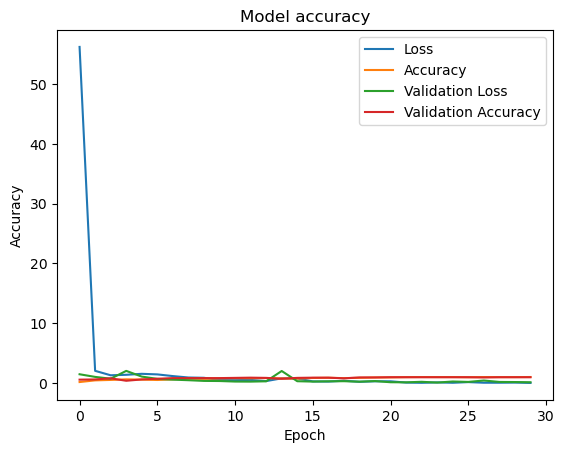

In [9]:
# Plotting the performance parameters
import matplotlib.pyplot as plt
plt.plot(history.history["loss"])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Loss","Accuracy","Validation Loss","Validation Accuracy"])
plt.show()

In [10]:
# Generating Test Data
test_datagen = ImageDataGenerator(rescale= 1./255.0,
        rotation_range = 50,
        horizontal_flip = True,
        shear_range = 0.2,
        validation_split = 0.2)


test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=32, shuffle = False)
# Checking the Model against Test Data
predictions = model_final.predict_generator(test_generator, steps=28, verbose=1)

Found 151 images belonging to 6 classes.


C:\Users\saisc\AppData\Local\Temp\ipykernel_13996\1028197578.py:12: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_final.predict_generator(test_generator, steps=28, verbose=1)


28/28 [==============================] - 4s 91ms/step


In [11]:
test_class = test_generator.classes
test_class

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

In [13]:
# get the class with highest probability for each sample
import numpy as np
y_pred = np.argmax(predictions, axis=-1)

In [14]:
# Final Performace Rating
print(classification_report(test_class, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.85      0.90        41
           1       0.85      0.79      0.81        14
           2       0.96      1.00      0.98        24
           3       0.94      0.94      0.94        18
           4       0.88      0.97      0.92        36
           5       1.00      1.00      1.00        18

    accuracy                           0.93       151
   macro avg       0.93      0.93      0.93       151
weighted avg       0.93      0.93      0.93       151

